In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from Forcasting_lib import load_fred_data, make_stationary, standardize_data

In [ ]:
## load and transform data
rng = np.random.default_rng(8927)  # Set random seed for reproducibility
df, transform_codes = load_fred_data()
df_stationary = make_stationary(df, transform_codes)

cols_to_standardize = [
    'GDPC1',      # Reales BIP
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel  #fehlt ein Wert 
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500'       # S&P 500 Index
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

Datei 'current.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.


In [5]:
data = df_std[cols_to_standardize].dropna()
data = pd.DataFrame(data)

### Define the model

In [ ]:
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta


## model definition 
def make_model(n_lags, df, priors, mv_norm=True, prior_checks=True):
    n_eqs = len(df.columns)
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )
        #data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)
        data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"])


        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
                dims=["time", "equations"]
        )
        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(draws=1000, random_seed=130))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
    return model, idata

In [6]:
n_eqs = data.shape[1]
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}

In [ ]:
model, idata = make_model(n_lags=2, data=data, priors=priors, prior_checks=False)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 102 seconds.
Sampling: [obs]


Output()

In [ ]:
def shade_background(ppc, ax, idx, palette="cividis"):
    palette = palette
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            ppc[:, idx, :],
            p,
            axis=1,
        )
        lower = np.percentile(
            ppc[:, idx, :],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        ax[idx].fill_between(
            x=np.arange(ppc.shape[0]),
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )


def plot_ppc(idata, df, group="posterior_predictive"):
    fig, axs = plt.subplots(df.shape[1], 1, figsize=(25, 15))
    
    obs_df = pd.DataFrame(idata["observed_data"]["obs"].data, columns=df.columns)
    
    axs = axs.flatten()
    ppc = az.extract(idata, group=group, num_samples=100)["obs"]

    for i in range(df.shape[1]):
        axs[i].plot(obs_df.iloc[:, i], label="Observed")
        axs[i].plot(ppc[:, :, i].T, color="gray", alpha=0.2)
        axs[i].set_title(f"VAR Series {i+1}")
        axs[i].legend()

    plt.tight_layout()



plot_ppc(idata, data)

NameError: name 'idata' is not defined

### Mit Forcasting 

In [7]:
def forecast_1step(lag_coefs, alpha, history, n_lags):
    """
    Forecast a single step ahead using a VAR(p) model.
    
    Parameters:
    - lag_coefs: array of shape (n_eqs, n_lags, n_eqs)
    - alpha: array of shape (n_eqs,)
    - history: array of shape (n_obs, n_eqs)
    - n_lags: integer
    
    Returns:
    - y_next: array of shape (n_eqs,)
    """
    n_eqs = history.shape[1]
    y_next = np.zeros(n_eqs)

    for j in range(n_eqs):  # for each output equation
        for i in range(n_lags):  # for each lag
            y_lag = history[-(i + 1)]
            y_next[j] += np.dot(lag_coefs[j, i], y_lag)
        y_next[j] += alpha[j]
    
    return y_next


### For the whole time series 

In [ ]:
y_preds = []
y_trues = []

for i in range((150), len(data)-1):
    model, idata = make_model(n_lags, data[:i], priors, prior_checks=False)
    lag_coefs_post = idata.posterior["lag_coefs"].mean(dim=["chain", "draw"]).values  # (n_eqs, n_lags, n_eqs)
    alpha_post = idata.posterior["alpha"].mean(dim=["chain", "draw"]).values          # (n_eqs,)

    history = data.values  # shape (n_obs, n_eqs)

    # Forecast
    y_next = forecast_1step(lag_coefs_post, alpha_post, history, n_lags=2)
    y_preds.append(y_next)
    y_trues.append(data.iloc[i+1].values)

### Mit Intervallen

In [8]:
y_preds = []
y_trues = []
y_preds_samples = []

n_draws = 500 
n_lags = 2  #

for i in range(150, len(data) - 1):
    df_train = data[:i]

    model, idata = make_model(n_lags, df_train, priors, prior_checks=False)

    # Get posterior samples
    lag_coefs_samples = idata.posterior["lag_coefs"].stack(sample=("chain", "draw")).values  # (n_eqs, n_lags, n_eqs, samples)
    alpha_samples = idata.posterior["alpha"].stack(sample=("chain", "draw")).values           # (n_eqs, samples)

    # Reduce to n_draws (if necessary)
    if lag_coefs_samples.shape[-1] > n_draws:
        idx = np.random.choice(lag_coefs_samples.shape[-1], n_draws, replace=False)
        lag_coefs_samples = lag_coefs_samples[..., idx]
        alpha_samples = alpha_samples[..., idx]

    # Last observed values (as lag input)
    history = df_train.values

    preds_i = []
    for s in range(n_draws):
        lag_coefs = lag_coefs_samples[..., s]  # (n_eqs, n_lags, n_eqs)
        alpha = alpha_samples[..., s]          # (n_eqs,)
        y_next = forecast_1step(lag_coefs, alpha, history, n_lags=n_lags)
        preds_i.append(y_next)

    # Forecast
    preds_i = np.array(preds_i)  # (n_draws, n_eqs)
    y_preds.append(preds_i.mean(axis=0))  # mean forecast
    y_preds_samples.append(preds_i)       # keep full samples
    y_trues.append(data.iloc[i + 1].values)


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 280 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1075 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 82 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 133 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 135 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 135 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 135 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 138 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 141 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 138 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 134 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 257 seconds.
Sampling: [obs]


Output()

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha, lag_coefs, noise_chol, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise_chol]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 93 seconds.
Sampling: [obs]


Output()

In [9]:
y_preds_samples = np.array(y_preds_samples)  # (n_forecasts, n_draws, n_eqs)
y_preds = np.array(y_preds)                 # (n_forecasts, n_eqs)
y_trues = np.array(y_trues)                 # (n_forecasts, n_eqs)

# Compute 95% interval
lower = np.percentile(y_preds_samples, 2.5, axis=1)   # shape (n_forecasts, n_eqs)
upper = np.percentile(y_preds_samples, 97.5, axis=1)  # shape (n_forecasts, n_eqs)


In [ ]:
BVAR_results = pd.DataFrame({
    "date": df_std.index[-len(y_preds):],
    "y_true": y_trues[:, 0],
    "y_pred": y_preds[:, 0],
    'lower_bounds': lower[:, 0] ,
    'upper_bounds': upper[:, 0] 
})

BVAR_results.to_csv('./Data/results/BVAR_forecast_results.csv', index=True)

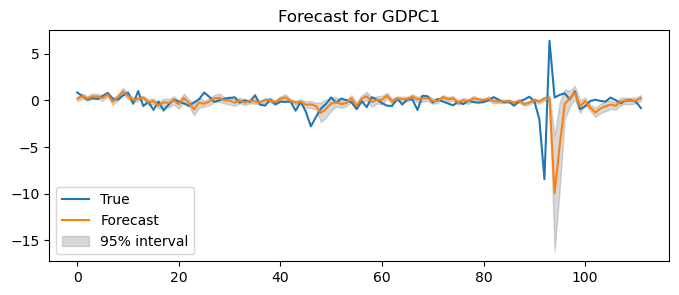

In [25]:
plt.figure(figsize=(8, 3))
plt.plot(y_trues[:, 0], label="True")
plt.plot(y_preds[:, 0], label="Forecast")
plt.fill_between(
        np.arange(len(y_preds)),
        lower[:, 0],
        upper[:, 0],
        color="gray",
        alpha=0.3,
        label="95% interval",
    )
plt.title(f"Forecast for {data.columns[0]}")
plt.legend()
plt.show()

### Nutze größeren Prädiktorensatz

In [8]:
cols_to_standardize = [
    'GDPC1',      # Reales BIP, Zielvariable
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'TB3MS',       # Rendite 3-monatiger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500',    # S&P 500 Index
    'PCECC96',    # PCE-Kerninflation
    'GPDIC1',     # Bruttoinlandsinvestitionen (real)
    'PNFIx',      # Private nichtwohnwirtschaftliche Investitionen
    'FPIx',       # Ausrüstungsinvestitionen
    'PCDGx',      # Konsum langlebiger Güter
    'PCNDx',      # Konsum nicht langlebiger Güter
    'PCESVx',     # Konsum von Dienstleistungen
    'CE16OV',     # Zivilbeschäftigung
    'CPIAUCSL',   # Verbraucherpreisindex (CPI)
    'PCEPILFE'    # PCE-Kerninflation
]

df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

## Daten vorbereiten
data = df_std[cols_to_standardize].dropna()
data = pd.DataFrame(data)

Standardisierung abgeschlossen.


In [9]:
n_eqs = data.shape[1]
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}

In [20]:
y_preds = []
y_trues = []
y_preds_samples = []

n_lags = 2  #

for i in range(150, len(data) - 1):
    df_train = data[:i]

    model, idata = make_model(n_lags, df_train, priors, mv_norm=False, prior_checks=False)

    # Get posterior samples
    lag_coefs_samples = idata.posterior["lag_coefs"].stack(sample=("chain", "draw")).values  # (n_eqs, n_lags, n_eqs, samples)
    alpha_samples = idata.posterior["alpha"].stack(sample=("chain", "draw")).values     # (n_eqs, samples)

    # Reduce to n_draws (if necessary)
    if lag_coefs_samples.shape[-1] > n_draws:
        idx = np.random.choice(lag_coefs_samples.shape[-1], n_draws, replace=False)
        lag_coefs_samples = lag_coefs_samples[..., idx]
        alpha_samples = alpha_samples[..., idx]

    # Last observed values (as lag input)
    history = df_train.values

    preds_i = []
    for s in range(n_draws):
        lag_coefs = lag_coefs_samples[..., s]  # (n_eqs, n_lags, n_eqs)
        alpha = alpha_samples[..., s]          # (n_eqs,)
        y_next = forecast_1step(lag_coefs, alpha, history, n_lags=n_lags)
        preds_i.append(y_next)

    # Forecast
    preds_i = np.array(preds_i)  # (n_draws, n_eqs)
    y_preds.append(preds_i.mean(axis=0))  # mean forecast
    y_preds_samples.append(preds_i)       # keep full samples
    y_trues.append(data.iloc[i + 1].values)


Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 571 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 640 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1021 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 134 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 736 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1178 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 595 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1033 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 854 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1075 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
Sampling: [obs]


Output()

Sampling: [alpha, lag_coefs, noise, obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, alpha, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

In [28]:
y_preds_samples = np.array(y_preds_samples)  # (n_forecasts, n_draws, n_eqs)
y_preds = np.array(y_preds)                 # (n_forecasts, n_eqs)
y_trues = np.array(y_trues)                 # (n_forecasts, n_eqs)

# Compute 95% interval
lower = np.percentile(y_preds_samples, 2.5, axis=1)   # shape (n_forecasts, n_eqs)
upper = np.percentile(y_preds_samples, 97.5, axis=1)  # shape (n_forecasts, n_eqs)

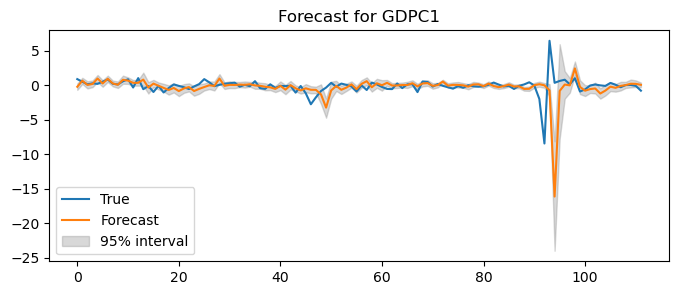

In [29]:
plt.figure(figsize=(8, 3))
plt.plot(y_trues[:, 0], label="True")
plt.plot(y_preds[:, 0], label="Forecast")
plt.fill_between(
        np.arange(len(y_preds)),
        lower[:, 0],
        upper[:, 0],
        color="gray",
        alpha=0.3,
        label="95% interval",
    )
plt.title(f"Forecast for {data.columns[0]}")
plt.legend()
plt.show()

In [ ]:
BVAR_results = pd.DataFrame({
    "date": df_std.index[-len(y_preds):],
    "y_true": y_trues[:, 0],
    "y_pred": y_preds[:, 0],
    'lower_bounds': lower[:, 0] ,
    'upper_bounds': upper[:, 0] 
})

BVAR_results.to_csv('./Data/results/BVAR_forecast_2_results.csv', index=True)